
# Training a model for automated curation

If the pretrained models do not give satisfactory performance on your data, it is easy to train your own classifier using SpikeInterface.


In [1]:
import warnings
warnings.filterwarnings("ignore")
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import spikeinterface.core as si
import spikeinterface.widgets as sw


# Note, you can set the number of cores you use using e.g.
# si.set_global_job_kwargs(n_jobs = 8)

In [2]:
# In the cell below If you're getting an import error, try adding the root path manually in your notebook:

## how to add root path manually is shown below 
# import sys
# sys.path.append(r"C:\Users\jain\Documents\GitHub\UnitRefine") # path to UnitRefine in locally directory

In [11]:
from UnitRefine.scripts.train_manual_curation import train_model

## import from Spikeinterface package
#from spikeinterface.curation import train_model

## Step 1: Generate and label data

For this tutorial, we will use simulated data to create ``recording`` ``sorting`` objects. We'll
create two sorting objects: :code:`sorting_1` is coupled to the real recording, so will contain good
units; :code:`sorting_2` is uncoupled, so should produce noise. We'll combine the two into one sorting
object using :code:`si.aggregate_units`.

(When making your own model, you should
[load your own recording](https://spikeinterface.readthedocs.io/en/latest/modules/extractors.html)
and [do a sorting](https://spikeinterface.readthedocs.io/en/latest/modules/sorters.html) on your data.)



In [4]:
recording, sorting_1 = si.generate_ground_truth_recording(num_channels=4, seed=1, num_units=10)
_, sorting_2 =si.generate_ground_truth_recording(num_channels=4, seed=2, num_units=10)

both_sortings = si.aggregate_units([sorting_1, sorting_2])

Skipping property 'gt_unit_locations' due to shape inconsistency


The models are based on [quality metrics](https://spikeinterface.readthedocs.io/en/latest/modules/qualitymetrics.html)
and [template metrics](https://spikeinterface.readthedocs.io/en/latest/modules/postprocessing.html#template-metrics),
which are computed using a :code:`sorting_analyzer`. So we'll now create a sorting
analyzer and compute the extensions needed to get the metrics.



In [5]:
analyzer = si.create_sorting_analyzer(sorting = both_sortings, recording=recording)
analyzer.compute(['noise_levels','random_spikes','waveforms','templates','spike_locations','spike_amplitudes','correlograms','principal_components','quality_metrics','template_metrics'])

estimate_sparsity:   0%|          | 0/10 [00:00<?, ?it/s]

noise_level:   0%|          | 0/20 [00:00<?, ?it/s]

compute_waveforms:   0%|          | 0/10 [00:00<?, ?it/s]

Fitting PCA:   0%|          | 0/20 [00:00<?, ?it/s]

Projecting waveforms:   0%|          | 0/20 [00:00<?, ?it/s]

Compute : spike_locations + spike_amplitudes:   0%|          | 0/10 [00:00<?, ?it/s]

noise_level:   0%|          | 0/20 [00:00<?, ?it/s]

calculate pc_metrics:   0%|          | 0/20 [00:00<?, ?it/s]

Let's plot the templates for the first and fifth units. The first (unit id 0) belongs to
:code:`sorting_1` so should look like a real unit; the sixth (unit id 5) belongs to :code:`sorting_2`
so should look like noise.



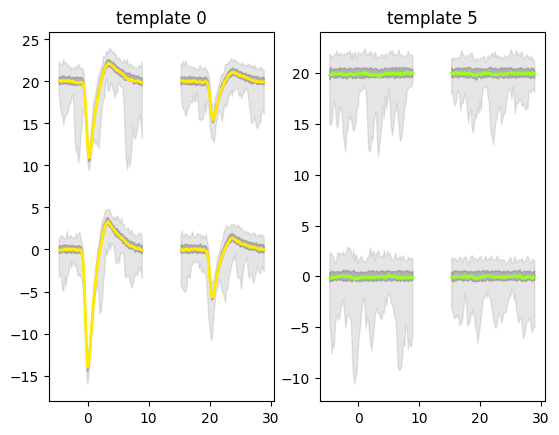

In [6]:
sw.plot_unit_templates(analyzer, unit_ids=[0,5])

This is as expected: great! Find out more about plotting using widgets [here](https://spikeinterface.readthedocs.io/en/latest/modules/widgets.html). The labels
for our units are then easy to put in a list:



In [7]:
labels = ['good', 'good', 'good', 'good', 'good', 'bad', 'bad', 'bad', 'bad', 'bad','good', 'good', 'good', 'good', 'good', 'bad', 'bad', 'bad', 'bad', 'bad']

## Step 2: Train our model

With the labelled data, we can train the model using the :code:`train_model` function.
Here, the idea is that the trainer will try several classifiers, imputation strategies and
scaling techniques then save the most accurate. To save time, we'll only try one classifier
(Random Forest), imputation strategy (median) and scaling technique (standard scaler).



In [8]:
folder = "my_model"

# We will use a list of one analyzer here, we would strongly advise using more than one to
# improve model performance
trainer = train_model(
    mode = "analyzers", # You can supply a labelled csv file instead of an analyzer
    labels = [labels],
    analyzers = [analyzer],
    folder = folder, # Where to save the model and model_info.json file
    metric_names = None, # Specify which metrics to use for training: by default uses those already calculted
    imputation_strategies = ["median"], # Defaults to all
    scaling_techniques = ["standard_scaler"], # Defaults to all
    classifiers = None, # Default to Random Forest only. Other classifiers you can try [ "AdaBoostClassifier","GradientBoostingClassifier","LogisticRegression","MLPClassifier"]
    overwrite = True # Whether or not to overwrite `folder` if it already exists. Default is False.
   
)

best_model = trainer.best_pipeline

Running RandomForestClassifier with imputation median and scaling StandardScaler()
BayesSearchCV from scikit-optimize not available, using RandomizedSearchCV


The above code saves the model in ``my_model/model.skops``, some metadata in
``my_model/model_info.json`` and the model accuracies in ``model_accuracies.csv``
in the specified ``folder``.

``skops`` is a file format: you can think of it as a more-secture pkl file. [Read more](https://skops.readthedocs.io/en/stable/index.html).

The ``model_accuracies.csv`` file contains the accuracy, precision and recall of the
tested models. Let's take a look



In [9]:
accuracies = pd.read_csv(Path(folder) / "model_accuracies.csv", index_col = 0)
accuracies.head()

,classifier name,imputation_strategy,scaling_strategy,balanced_accuracy,precision,recall,model_id,best_params
0,RandomForestClassifier,median,StandardScaler(),1.0,1.0,1.0,0,"{'n_estimators': 150, 'min_samples_split': 4, ..."


Our model is perfect!! This is because the task was *very* easy. We had 10 units; where
half were pure noise and half were not.

The model also contains some more information, such as which features are importantly.
We can plot these:



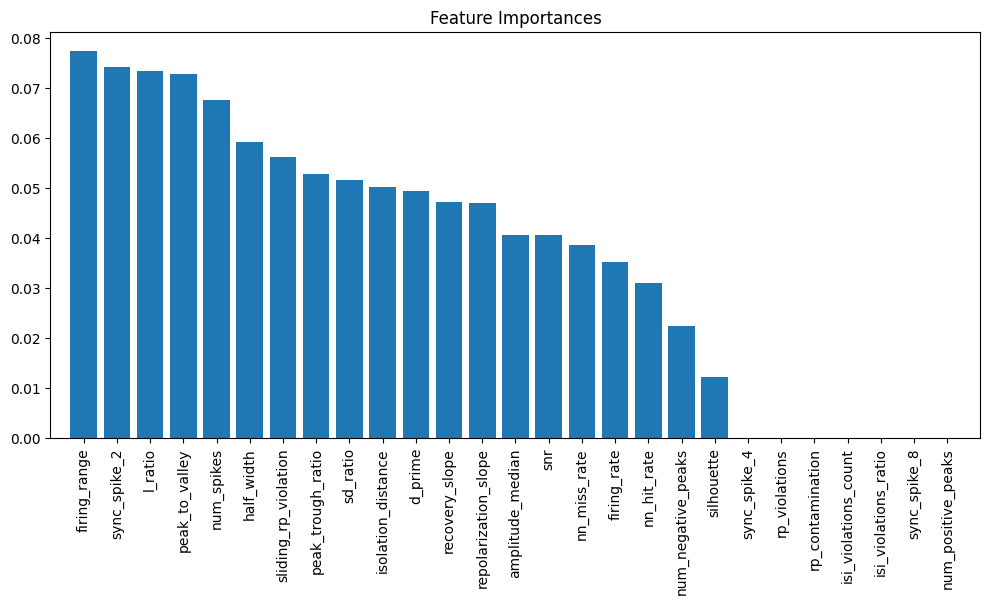

In [10]:
# Plot feature importances
importances = best_model.named_steps['classifier'].feature_importances_
indices = np.argsort(importances)[::-1]

# The sklearn importances are not computed for inputs whose values are all `nan`.
# Hence, we need to pick out the non-`nan` columns of our metrics
features = best_model.feature_names_in_
n_features = best_model.n_features_in_

metrics = pd.concat([analyzer.get_extension('quality_metrics').get_data(), analyzer.get_extension('template_metrics').get_data()], axis=1)
non_null_metrics = ~(metrics.isnull().all()).values

features = features[non_null_metrics]
n_features = len(features)

plt.figure(figsize=(12, 7))
plt.title("Feature Importances")
plt.bar(range(n_features), importances[indices], align="center")
plt.xticks(range(n_features), features[indices], rotation=90)
plt.xlim([-1, n_features])
plt.subplots_adjust(bottom=0.3)
plt.show()